**Group information**

| Family name | First name | Student ID | Email address              | UTORID |
| ----------- | ---------- | ---------- | ---------------------------| ------ |
|   Taskin    | Meric Sila | 1006247090 |sila.taskin@mail.utoronto.ca|taskinme|


# Convolutional networks - Practice (homework 3)

In this practice session, we implement and optimise a simple convolutional network to recognise handwritten digits.

In [38]:
# Modules
import numpy as np
import pydot # Requires installation

from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras import callbacks, datasets, initializers, layers, losses, models, optimizers, preprocessing, utils
from scipy import ndimage
from skimage import data, transform, util
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Utilities
def display(image:np.ndarray, title:str='', cmap:str='gray', figsize=(5, 5)) -> None:
    '''Displays an image'''
    fig, ax = pyplot.subplots(1, figsize=figsize)
    ax.imshow(image, cmap=cmap)
    ax.set_title(title, fontsize=20)
    ax.set_axis_off()
    pyplot.tight_layout()
    pyplot.show()

def compare(images:list, titles:list, cmap='gray', gridsize=(1, 2), figsize=(5, 5)) -> None:
    '''Displays multiple images'''
    fig, axs = pyplot.subplots(nrows=gridsize[0], ncols=gridsize[1], figsize=(figsize[1]*gridsize[1], figsize[0]*gridsize[0]))
    for ax, image, title in zip(axs.ravel(), images, titles):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title, fontsize=20)
        ax.set_axis_off()
    pyplot.tight_layout()
    pyplot.show()

def display_history(history:dict, stat:str='loss', validation:bool=False) -> None:
    '''Displays training history for a statistic'''
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(history[stat], label='Training sample')
    if validation:
        ax.plot(history[f'val_{stat}'], label='Validation sample')
    ax.set_title(f'Model training', fontsize=15)
    ax.set_ylabel(stat.title())
    ax.set_xlabel('Epoch')
    ax.legend(frameon=False)
    pyplot.tight_layout()
    pyplot.show()


1. Load the grayscale image `skimage.data.camera()` of dimensions $h \times w$ resize it to $100 \times 100$ (see `transform.resize`) and display the result.

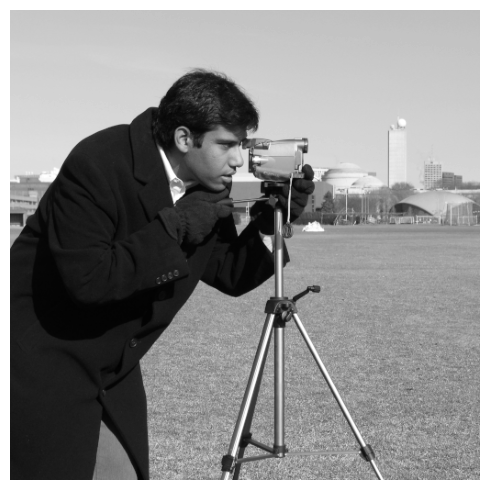

In [39]:
img = data.camera()
resized_img = transform.resize(img, (100, 100))
display(img)

2. Using a `np.array`, initialise a $3 \times 3$ kernel containing a Sobel operator for edge detection (i.e. horizontal or vertical), perform a convolution on the image (see `ndimage.convolve`). Display and explain the results.

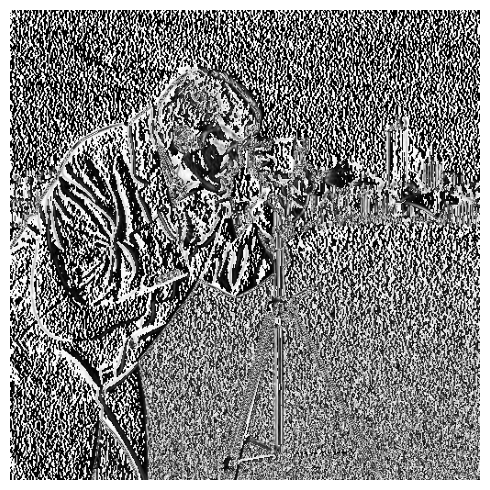

In [40]:
# Vertical Sobel kernel
kernel = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])
edges = ndimage.convolve(img, kernel)
display(edges)

The Sobel operator for edge detection (the vertical Sobel operator in this case) outputs the image where vertical edges are marked with bright pixels, as seen for example on the back of the man in the image above.

3. Implement manually ReLU activation and $2 \times 2$ maximum pooling (see `skimage.util.view_as_blocks`). Display and explain the results.

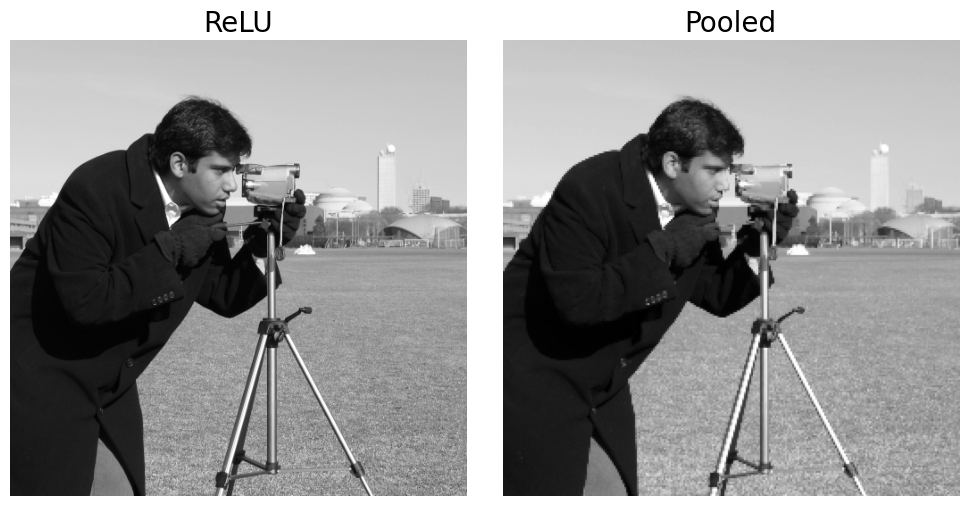

In [41]:
relu_img = np.maximum(img, 0)
pooled_img = util.view_as_blocks(relu_img, block_shape=(2, 2)).max(axis=(2, 3))

compare([relu_img, pooled_img], ['ReLU', 'Pooled'])

The ReLU activation function takes the negative valued pixels and changes their values to zero. The $2 \times 2$ max pooling function divides the image into equal sized blocks of size $2 \times 2$ i.e. 4 pixels and takes the maximum value of those four. This is why the Pooled image has lower resolution than the ReLU activated image. Both these methods are used to reduce the dimensionality of the images.

4. Load the MNIST dataset (see `keras.datasets.mnist.load_data`). Format the input as a $n \times h^{(0)} \times w^{(0)} \times d^{(0)}$ dimensional array (see `np.expand_dims`). The resulting array should have dimensions $n \times 28 \times 28 \times 1$ and type `float`.

In [42]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = np.expand_dims(train_images, axis=-1).astype('float32')
test_images = np.expand_dims(test_images, axis=-1).astype('float32')

5. Normalise the pixel intensities over the $[-1.0;1.0]$ range for each channel. Format the target array with dimensions $n \times k^{(L)}$ array where $k^{(L)}=10$ is the number of output classes (see `keras.utils.to_categorical`).

In [43]:
# First normalize to [0, 1]
train_images /= 255.0
test_images /= 255.0
# Then normalize to [-1, 1]
train_images = (train_images - 0.5) * 2.0
test_images = (test_images - 0.5) * 2.0

num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

6. Using the `keras` functional API, build the LeNet5 model structure (i.e. see lecture notes, `layers.Conv2D`, `layers.MaxPooling2D`) with `relu` activation for the hidden layers and the appropriate activation for the output layer. Choose the correct parameter initialisation technique. Use the `summary` method of the model to visualise its structure (alternatively, you can use `keras.utils.plot_model`).

Note: Don't forget to flatten the representation between the convolutional and the dense layers (see `layers.Flatten`).

In [47]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.initializers import he_normal

# Layers
input_layer = Input(shape=(28, 28, 1))
conv1 = Conv2D(6, (5, 5), padding='same', activation='relu', kernel_initializer=he_normal())(input_layer)
pool1 = MaxPooling2D((2, 2), strides=2)(conv1)
conv2 = Conv2D(16, (5, 5), padding='valid', activation='relu', kernel_initializer=he_normal())(pool1)
pool2 = MaxPooling2D((2, 2), strides=2)(conv2)
flatten = Flatten()(pool2)
fc1 = Dense(120, activation='relu', kernel_initializer=he_normal())(flatten)
fc2 = Dense(100, activation='relu', kernel_initializer=he_normal())(fc1)
output_layer = Dense(10, activation='softmax')(fc2)

# Model
model = Model(inputs=input_layer, outputs=output_layer, name= 'LeNet5')
model.summary()

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 400)               0    

7. Compile and the model using an appropriate loss function and optimiser. Estimate the parameters on the training sample and use 20% of the observations for validation. Use early stopping to prevent overfitting (see `keras.callbacks`).

In [48]:
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_images, train_labels, validation_split=0.2, batch_size=30, epochs=50, callbacks=[early_stopping], verbose=0)

8. Display the optimisation path for the training and the validation samples. Compute the predictive performance on the test sample and display the confusion matrix. Which portion of the test sample is correcly classified?

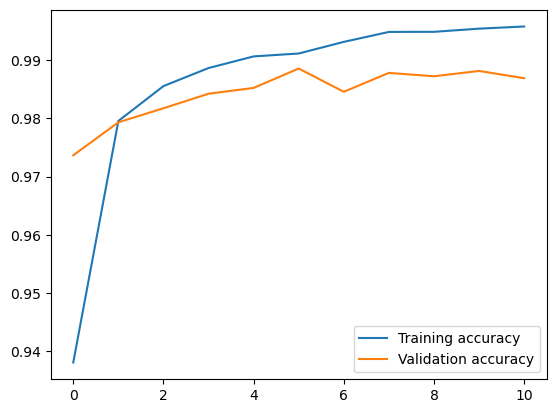

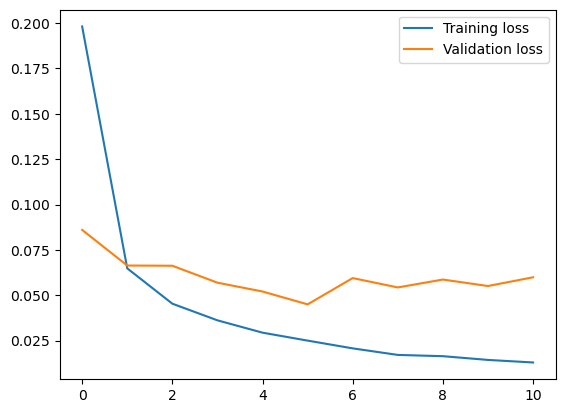

Test accuracy: 0.9889
313/313 [==============================] - 1s 3ms/step
[[ 977    0    0    0    0    0    0    1    2    0]
 [   0 1133    0    0    0    0    1    1    0    0]
 [   1    2 1024    0    1    0    0    2    2    0]
 [   0    1    1 1002    0    2    0    2    2    0]
 [   0    0    2    0  974    0    0    1    0    5]
 [   1    1    0   11    0  874    1    0    1    3]
 [   9    2    0    0    2    1  941    0    3    0]
 [   0    4    6    1    0    0    0 1014    1    2]
 [   2    1    3    0    0    0    0    1  964    3]
 [   0    2    1    1    7    3    0    6    3  986]]


In [49]:
from matplotlib import pyplot as plt

# Plot accuracy for train and val datasets
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

# Plot loss for train and val datasets
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

# Confusion matrix
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)
confusion = confusion_matrix(y_true, y_pred)
print(confusion)

Looking at the diagonal confusion matrix, we can see how many correct classifications were made for each of the classes (numbers). 

9. Attach a batch-normalisation layer to each hidden layer in the appropriate position (see `layers.BatchNormalization` and `layers.Activation`) and re-estimate the model as in question (7). Explain how batch-normalisation can improve predictive performance.

Note: the constant term or `bias` becimes redundant when using batch-normalisation layers. Set `use_bias=False` for convolutional and dense layers.

In [50]:
from keras import layers, models
from keras.layers import BatchNormalization, Activation

# Layers
input_layer = Input(shape=(28, 28, 1))
conv1 = Conv2D(6, (5, 5), padding='valid', activation=None, use_bias=False)(input_layer)
batch_norm1 = BatchNormalization()(conv1)
act1 = Activation('relu')(batch_norm1)
pool1 = MaxPooling2D((2, 2), strides=2)(act1)
conv2 = Conv2D(16, (5, 5), padding='valid', activation=None, use_bias=False)(pool1)
batch_norm2 = BatchNormalization()(conv2)
act2 = Activation('relu')(batch_norm2)
pool2 = MaxPooling2D((2, 2), strides=2)(act2)
flatten = Flatten()(pool2)
fc1 = Dense(120, activation=None, use_bias=False)(flatten)
batch_norm3 = BatchNormalization()(fc1)
act3 = Activation('relu')(batch_norm3)
fc2 = Dense(100, activation=None, use_bias=False)(act3)
batch_norm4 = BatchNormalization()(fc2)
act4 = Activation('relu')(batch_norm4)
output_layer = Dense(10, activation='softmax')(act4)

# Model 
model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=50, batch_size=30, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

# Confusion Matrix
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)
confusion = confusion_matrix(y_true, y_pred)
print(confusion)

Test accuracy: 0.9903
313/313 [==============================] - 1s 2ms/step
[[ 976    0    1    0    0    0    2    1    0    0]
 [   0 1129    1    0    0    1    1    3    0    0]
 [   1    2 1023    0    0    0    1    5    0    0]
 [   0    0    1 1000    0    4    0    4    1    0]
 [   0    0    0    0  976    0    3    1    0    2]
 [   1    0    0    5    0  880    4    1    0    1]
 [   7    5    1    0    2    1  942    0    0    0]
 [   0    2    3    2    0    0    0 1021    0    0]
 [   2    0    3    1    0    0    0    0  967    1]
 [   1    0    0    0    6    2    0   10    1  989]]


By using batch normalization in each layer, we normalize the batch used for training so that it has mean 0 and variance 1. This helps avoid "internal covariate shift", which refers to changing activation distributions in each layer because of the changing parameters during training. Batch normalization improves accuracy and prevents overfitting. 

10. Looking at the optimisation path, do you expect dropout to increase performance. If so, add a spatial dropout layer to the model after each convolution (see `layers.SpatialDropout2D`) so that $10\%$ of the representations along $d^{(l)}$ are dropped at each optimisation iteration, and re-estimate the model as in question (7).

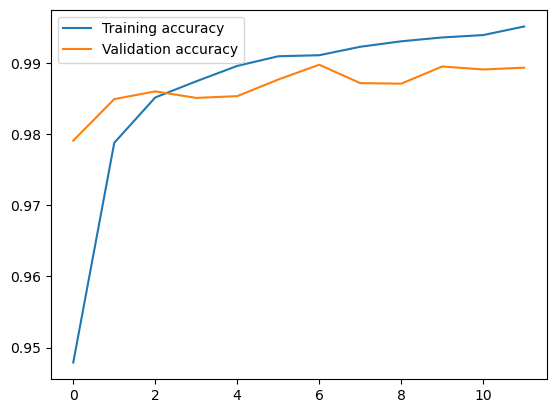

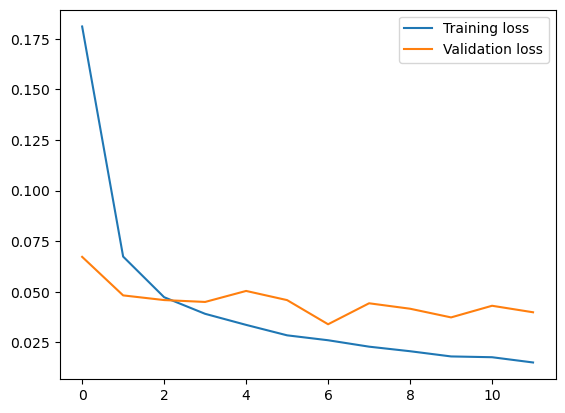

In [51]:
# Plot optimization path

from matplotlib import pyplot as plt

# Plot accuracy for train and val datasets
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

# Plot loss for train and val datasets
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

Based on the optimisation path, we can see that the training loss continuously decreases whereas the validation loss follows an unstable zig-zag like trajectory. This could mean that the model is overfitting the training dataset in which case adding spatial dropout layers could help. So we will check whether the model performance improves when we add dropout layers.

In [52]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, SpatialDropout2D

# Layers
input_layer = Input(shape=(28, 28, 1))
conv1 = Conv2D(6, (5, 5), padding='valid', activation=None, use_bias=False)(input_layer)
batch_norm1 = BatchNormalization()(conv1)
act1 = Activation('relu')(batch_norm1)
dropout1 = SpatialDropout2D(0.1)(act1)
pool1 = MaxPooling2D((2, 2), strides=2)(dropout1)

conv2 = Conv2D(16, (5, 5), padding='valid', activation=None, use_bias=False)(pool1)
batch_norm2 = BatchNormalization()(conv2)
act2 = Activation('relu')(batch_norm2)
dropout2 = SpatialDropout2D(0.1)(act2)
pool2 = MaxPooling2D((2, 2), strides=2)(dropout2)

flatten = Flatten()(pool2)
fc1 = Dense(120, activation=None, use_bias=False)(flatten)
batch_norm3 = BatchNormalization()(fc1)
act3 = Activation('relu')(batch_norm3)
fc2 = Dense(100, activation=None, use_bias=False)(act3)
batch_norm4 = BatchNormalization()(fc2)
act4 = Activation('relu')(batch_norm4)
output_layer = Dense(10, activation='softmax')(act4)

# Model 
model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=50, batch_size=30, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.9900


The test accuracy has in fact dropped a tiny bit, so the spatial dropout layers seem to be unnecessary.

11. **OPTIONAL**. Use an image generator to apply random transformation to each image before fitting the model (see `preprocessing.image.ImageDataGenerator`). The transformations should include small rotations, and small zooming and dezooming. How do you expect augmentation to improve predictive performance?

Note: Note that the `validation_split` should be specified in the generator. The training and the validation samples can be retireved after fitting the generator using the `subset` argument. Using generators requires to specify `steps_per_epoch` and `validation_steps` as the number of observations in the sample divided by the `batch_size` in the training parameters.

References:

* https://www.kaggle.com/code/curiousprogrammer/lenet-5-cnn-with-keras-99-48
* https://github.com/PJY-609/LeNet-5-MNIST
* Ioffe, S., &amp; Szegedy, C. (2015, March 2). Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv.org. Retrieved April 8, 2023, from https://arxiv.org/abs/1502.03167 
* Lecun, Y. et al. (1998). "Gradient-based learning applied to document recognition".
